# Wavefield Reconstruction of Cook Inlet DAS Data with SHallow Recurrent Decoder

**Author:** Yiyu Ni (niyiyu@uw.edu)

**Last updated:** Dec 3, 2025

This notebook demonstrates the use of deep-learning model to compress and reconstruct wavefields recorded by offshore DAS. We demonstrate that SHallow REcurrent Decoders (SHRED) provide an effective framework to compress DAS data, enabling lower streaming rates, and being effective at reconstructing wavefield from ocean wave that composes the broadband DAS data.

---

In [ ]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import *

IMAGE_KWARGS = {"cmap": "RdBu", "vmax": 5, "vmin": -5, "aspect": "auto", "origin": "lower"}
TEXT_KWARGS = {"fontsize": 15, "color": "#c00000"}

---

### Cook Inlet DAS experiment
Two seafloor telecommunication cables owned by the GCI Communication Corporation are used that originate from the landing station in Homer, Alaska: the Terrestrial for Every Rural Region (TERRA) runs westward to the Iliamna Bay, near Augustine Volcano, and the southern span of the Kodiak Kenai Fiber Link (KKFL‐S) that connects Kenai peninsula and the Kodiak archipelago. Beginning June 2023, both cables have been connected to a Sintela Onyx v1.0 interrogator unit in the GCI landing station for continuous data acquisition. The team has built a heterogeneous edge unit with a Network‐Attached‐System (NAS) for year‐long continuous data storage (∼160 TB), and two CPU and GPU edge computing servers for data processing. The interrogator unit saves the raw data at a 25 Hz sampling rate and further decimates it into 2.5 Hz; both raw and decimated data are saved. There are 8,531 channels using a 9.47 m channel spacing with a gauge length of 23.93 m between September and December.

<div>
<img src="https://raw.githubusercontent.com/niyiyu/DAS-reconstruction/refs/heads/main/docs/map.png" width="500"/>
</div>

The earthquake data from the Cook Inlet DAS experiment are hosted at https://dasway.ess.washington.edu/gci. Earthquakes and daily data reports were updated daily. Here, we download a two-minute event file recorded on September 24, 2023 on the KKFLS cable. The event has an internal id 11748611 and you can find the USGS event report [here](https://earthquake.usgs.gov/earthquakes/eventpage/ak023c9uv1bq/executive).

In [2]:
!wget "https://dasway.ess.washington.edu/gci/events/2023-09-24/11748611/KKFLS.h5" -O KKFLS.h5

--2025-11-24 13:29:35--  https://dasway.ess.washington.edu/gci/events/2023-09-24/11748611/KKFLS.h5
Resolving dasway.ess.washington.edu (dasway.ess.washington.edu)... 128.208.23.57
Connecting to dasway.ess.washington.edu (dasway.ess.washington.edu)|128.208.23.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102420064 (98M) [application/octet-stream]
Saving to: ‘KKFLS.h5’

KKFLS.h5            100%[===================>]  97.67M  4.60MB/s    in 21s     

2025-11-24 13:29:57 (4.58 MB/s) - ‘KKFLS.h5’ saved [102420064/102420064]



Here, we open the file and retrieve the DAS data from channel **nc_start** to **nc_end** (1000 channels in toal). The data is sampled at 25 Hz.

In [4]:
nc_start = 1000
nc_end = 2000
fs = 25

f = h5py.File("./KKFLS.h5", 'r', locking=False)
raw = f['/Acquisition/Raw[0]/RawData'][:, nc_start:nc_end].T
raw -= np.mean(raw, axis=-1, keepdims=True)
raw /= np.std(raw, axis=-1, keepdims=True)
f.close()

print(f"Got data array with {raw.shape} (channel, time)")

Got data array with (1000, 3000) (channel, time)


Text(0.5, 0, 'Time (sec)')

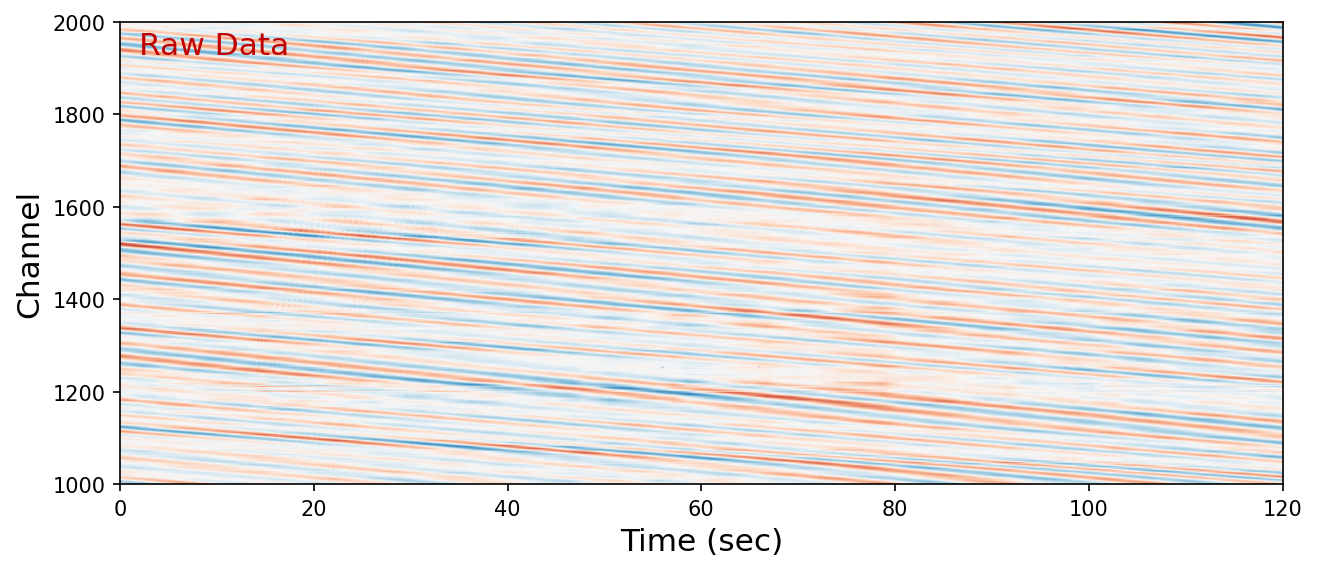

In [5]:
plt.figure(figsize=(10, 4), dpi=150)
plt.imshow(raw, extent=[0, 120, nc_start, nc_end], **IMAGE_KWARGS)
plt.ylabel("Channel", fontsize=15)
plt.text(2, nc_end-70, "Raw Data", **TEXT_KWARGS)
plt.xlabel("Time (sec)", fontsize=15)

### SHallow REcurrent Decoder (SHRED)

SHRED was designed to take a short time series (sensory temporal trajectory) of a field sampled on a sparse network and reconstruct the current state of the field in a dense, spatial array. The adapted SHRED model takes inputs as the strain rate time series measured before and at the current time $T_0$ from $N_{input}$ channels and reconstructs the spatial wavefield snapshot at time $T_0$ of $N_{output}$ continuous channel, from which the inputs are decimated.

<div>
<img src="https://raw.githubusercontent.com/niyiyu/DAS-reconstruction/refs/heads/main/docs/shred.png" width="800"/>
</div>

Below, we define model parameters and load the pretrained SHRED model.


In [ ]:
class SHRED(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=0.1
        )
        self.sdn1 = torch.nn.Linear(hidden_size, output_size // 2)
        self.sdn3 = torch.nn.Linear(output_size // 2, output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.lstm(x)[1][0][-1]
        x = self.relu(self.sdn1(x))
        x = self.sdn3(x)
        return x

In [ ]:
n_lag = 100
n_channel = 101
n_hidden = 256
n_output = 1000
n_lstm = 2

model = SHRED(n_channel, n_hidden, n_output, n_lstm)
model.load_state_dict(torch.load("./SHRED_KKFLS_25Hz_101i_1000o_100sp.pt", 
                                 map_location=torch.device('cpu')))

print(f"The SHRED model has {count_weights(model)} weights")
model.eval()

The SHRED model has 1523452 weights


SHRED(
  (lstm): LSTM(101, 256, num_layers=2, batch_first=True, dropout=0.1)
  (sdn1): Linear(in_features=256, out_features=500, bias=True)
  (sdn3): Linear(in_features=500, out_features=1000, bias=True)
  (relu): ReLU()
)

### Reconstruction
The SHRED model uses downsampled DAS data as input, i.e., we select **n_channel** channels from **n_output** channels with a regular spacing. 

In [7]:
cidx = np.linspace(1, n_output, n_channel, dtype='int') - 1 # python convention
cidx

array([  0,   9,  19,  29,  39,  49,  59,  69,  79,  89,  99, 109, 119,
       129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249,
       259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 369, 379,
       389, 399, 409, 419, 429, 439, 449, 459, 469, 479, 489, 499, 509,
       519, 529, 539, 549, 559, 569, 579, 589, 599, 609, 619, 629, 639,
       649, 659, 669, 679, 689, 699, 709, 719, 729, 739, 749, 759, 769,
       779, 789, 799, 809, 819, 829, 839, 849, 859, 869, 879, 889, 899,
       909, 919, 929, 939, 949, 959, 969, 979, 989, 999])

In [8]:
raw_dsp = np.zeros_like(raw)
raw_dsp[cidx, :] = raw[cidx, :]

Text(0.5, 0, 'Time (sec)')

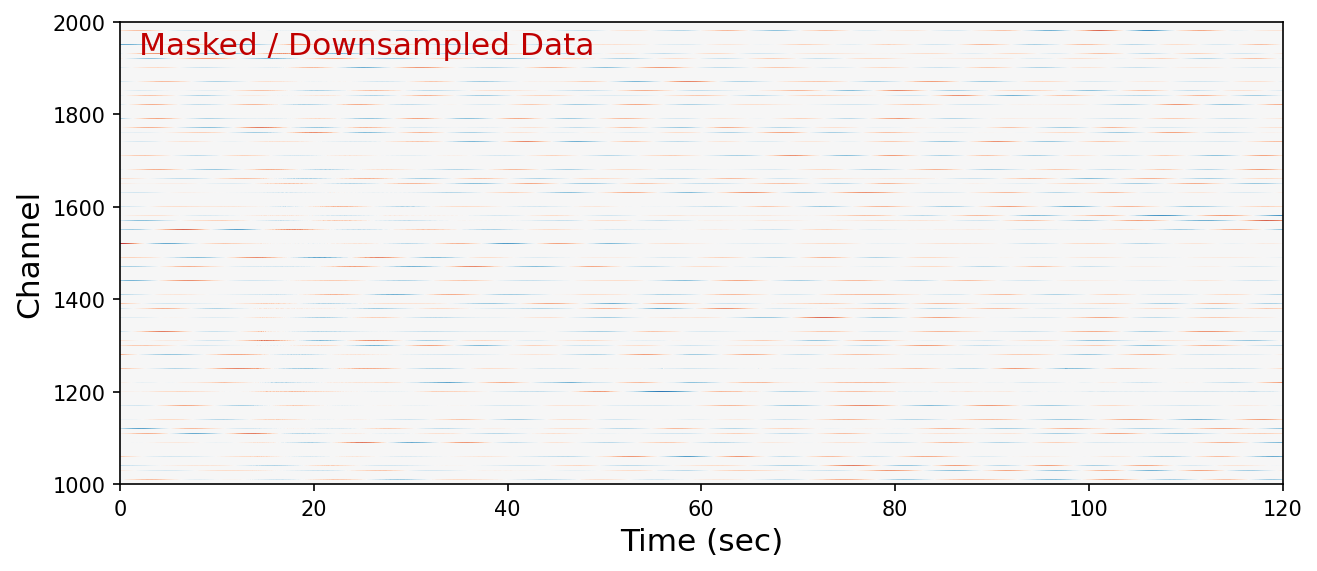

In [9]:
plt.figure(figsize=(10, 4), dpi=150)
plt.imshow(raw_dsp, extent=[0, 120, nc_start, nc_end], interpolation = "none", **IMAGE_KWARGS)
plt.ylabel("Channel", fontsize=15)
plt.text(2, nc_end-70, "Masked / Downsampled Data", **TEXT_KWARGS)
plt.xlabel("Time (sec)", fontsize=15)

In [10]:
rec = np.zeros_like(raw)
for idt in tqdm(range(n_lag, 3000), ncols=80):
    X = raw_dsp[cidx, idt-(n_lag-1):idt+1].T
    with torch.no_grad():
        rec[:, idt] = model(torch.tensor(X))

100%|██████████████████████████████████████| 2900/2900 [00:12<00:00, 241.17it/s]


Text(0.5, 0, 'Time (sec)')

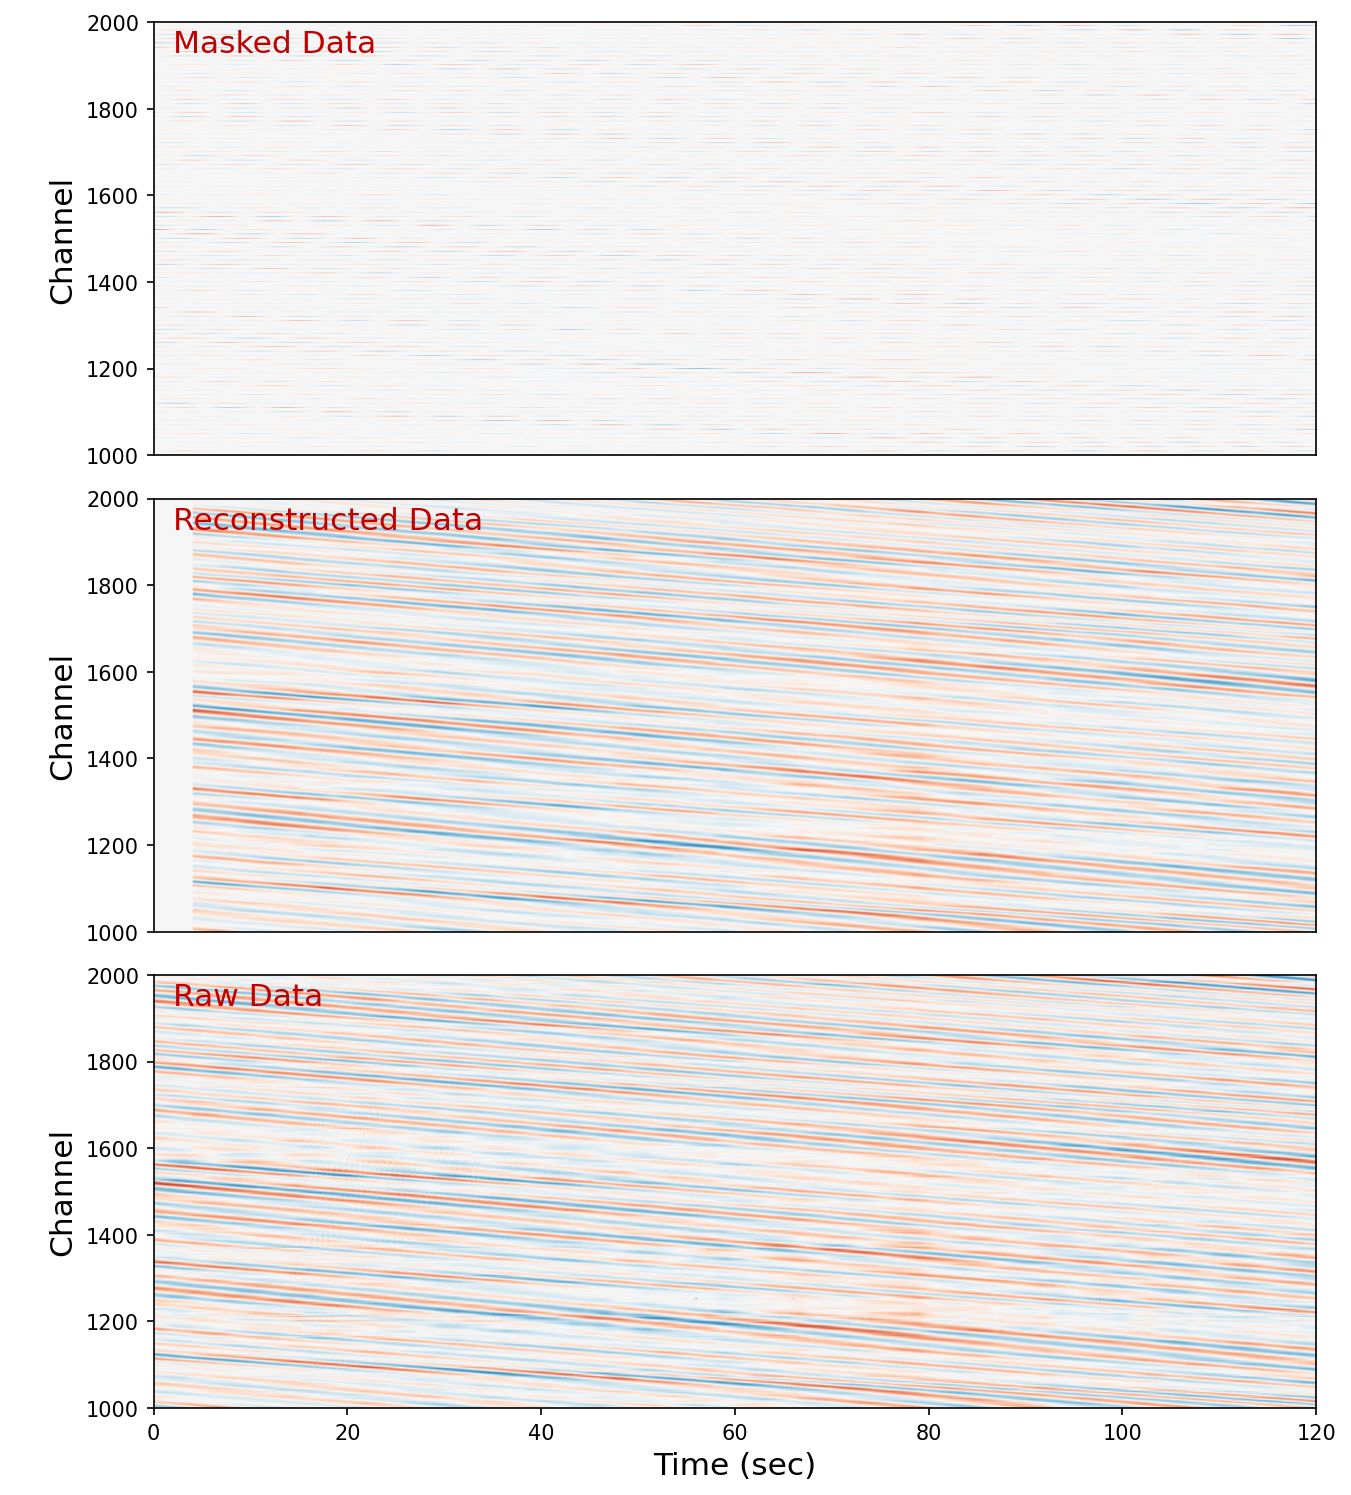

In [11]:
plt.figure(figsize=(10, 12), dpi=150)
plt.subplots_adjust(hspace=0.1)
plt.subplot(3, 1, 1)
plt.imshow(raw_dsp, extent=[0, 120, nc_start, nc_end], **IMAGE_KWARGS)
plt.text(2, nc_end-70, "Masked Data", **TEXT_KWARGS)
plt.xticks([])
plt.ylabel("\nChannel", fontsize=15)

plt.subplot(3, 1, 2)
plt.imshow(rec, extent=[0, 120, nc_start, nc_end], **IMAGE_KWARGS)
plt.text(2, nc_end-70, "Reconstructed Data", **TEXT_KWARGS)
plt.xticks([])
plt.ylabel("Channel", fontsize=15)

plt.subplot(3, 1, 3)
plt.imshow(raw, extent=[0, 120, nc_start, nc_end], **IMAGE_KWARGS)
plt.text(2, nc_end-70, "Raw Data", **TEXT_KWARGS)
plt.ylabel("\nChannel", fontsize=15)
plt.xlabel("Time (sec)", fontsize=15)

## Reference
* https://github.com/niyiyu/DAS-reconstruction
* Ni, Y., Denolle, M. A., Shi, Q., Lipovsky, B. P., Pan, S., & Kutz, J. N. (2024). Wavefield reconstruction of distributed acoustic sensing: Lossy compression, wavefield separation, and edge computing. Journal of Geophysical Research: Machine Learning and Computation, 1(3), e2024JH000247 [10.1029/2024JH000247](https://doi.org/10.1029/2024JH000247).
* Williams, J. P., Zahn, O., & Kutz, J. N. (2023). Sensing with shallow recurrent decoder networks. arXiv preprint arXiv:2301.12011.